In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA





In [2]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]
    
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         'feature_linear_trend_magn_r',
                         'feature_linear_trend_sigma_magn_r',
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         'feature_period_s_to_n_0_magn_r',
                         #'feature_period_1_magn_r', 
                         'feature_period_s_to_n_1_magn_r',
                         #'feature_period_2_magn_r', 
                         'feature_period_s_to_n_2_magn_r',
                         #'feature_period_3_magn_r', 
                         'feature_period_s_to_n_3_magn_r',
                         #'feature_period_4_magn_r', 
                         'feature_period_s_to_n_4_magn_r',
                         #'feature_periodogram_amplitude_magn_r',
                         'feature_periodogram_beyond_2_std_magn_r',
                         'feature_periodogram_beyond_3_std_magn_r',
                         'feature_periodogram_standard_deviation_magn_r', 
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         'feature_linear_trend_magn_g',
                         'feature_linear_trend_sigma_magn_g',
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         'feature_period_s_to_n_0_magn_g',
                         #'feature_period_1_magn_g', 
                         'feature_period_s_to_n_1_magn_g',
                         #'feature_period_2_magn_g', 
                         'feature_period_s_to_n_2_magn_g',
                         #'feature_period_3_magn_g', 
                         'feature_period_s_to_n_3_magn_g',
                         #'feature_period_4_magn_g', 
                         'feature_period_s_to_n_4_magn_g',
                         #'feature_periodogram_amplitude_magn_g',
                         'feature_periodogram_beyond_2_std_magn_g',
                         'feature_periodogram_beyond_3_std_magn_g',
                         'feature_periodogram_standard_deviation_magn_g', 
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']

In [3]:
dataset_bank = pd.read_csv('../loci_dbs/loci_df_271688objects_cut_stars_and_gal_plane_transf.csv', 
                                   compression='gzip',
                                   usecols=lambda c: c in ztf_id_and_features_r_g,
                                  index_col='ztf_object_id')
        
# drop row if any feature values are nan
dataset_bank = dataset_bank[~dataset_bank[feature_names_r_g].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
dataset_bank

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7,125,129,130,131,132,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,anom_score,anomaly_score,anomaly_mask,anomaly_type,is_corrected,vpdf_extreme_version,vpdf_extreme_faint,vpdf_extreme_bright,locus_gal_l,locus_gal_b
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.881532,-69.513571
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.200342,-26.246909
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.189482,-24.352953
ZTF17aaaskvj,59,ANT2018ftblk,28.015003,36.953216,"['lc_feature_extractor', 'high_snr']","['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1504,583,ztf_candidate:598425334815010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.189482,-24.352954
ZTF18aczbnhl,97,ANT2019dsk24,85.049145,-11.013302,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,105,12,ztf_candidate:718232301815010005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.961559,-20.751422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aberawv,999927,ANT2020aebbk,292.910293,54.078978,"['lc_feature_extractor', 'dimmers']",[],NaN,235,96,ztf_candidate:1231482062015010023,...,NaN,0.417276,Fail,TBD,NaN,NaN,NaN,NaN,85.961850,16.149525
ZTF18acrvsjf,999938,ANT2019zf6fg,72.820139,1.073984,['lc_feature_extractor'],"['allwise', 'bright_guide_star_cat', '2mass_ps...",NaN,40,14,ztf_candidate:696399341515010050,...,NaN,NaN,NaN,TBD,NaN,NaN,NaN,NaN,197.132900,-25.906137
ZTF18acdqrna,999957,ANT2020aefhrvi,53.476865,77.496741,['lc_feature_extractor'],"['allwise', 'bright_guide_star_cat', '2mass_ps...",NaN,83,36,ztf_candidate:1353408024115015003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.425108,17.392307


In [4]:
# only keep features of bank
dataset_bank_orig = dataset_bank[feature_names_r_g]
dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,feature_standard_deviation_magn_g,feature_stetson_k_magn_g,feature_weighted_mean_magn_g,feature_anderson_darling_normal_flux_g,feature_cusum_flux_g,feature_excess_variance_flux_g,feature_kurtosis_flux_g,feature_mean_variance_flux_g,feature_skew_flux_g,feature_stetson_k_flux_g
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,-0.001783,...,0.344664,0.833143,18.288298,-0.741267,0.244416,0.409971,-0.783581,-0.535533,-0.061333,0.815809
ZTF18acfvwwa,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,0.000145,...,0.255341,0.796845,17.025929,0.013852,0.276394,0.369215,0.319612,-0.616276,0.720649,0.746565
ZTF17aaaskvj,1.325100,0.305955,0.310345,0.194759,0.069613,1.452066,0.900613,0.490911,1.562089,-0.000205,...,0.384571,0.542215,16.768612,1.073154,0.119285,0.611570,4.490889,-0.309191,2.390988,0.613781
ZTF17aaaskvj,1.325100,0.300439,0.308219,0.194091,0.072355,1.448558,0.899251,0.491846,1.551687,-0.000213,...,0.386585,0.541809,16.773018,1.066396,0.119160,0.611631,4.488470,-0.309169,2.386820,0.613769
ZTF18aczbnhl,0.276431,-0.610376,0.250000,0.000000,0.370062,0.552862,0.552862,0.316462,1.948112,-0.000285,...,0.492342,0.871093,18.629537,-0.228569,0.247441,0.547583,-1.541604,-0.365630,0.163018,0.879632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aberawv,0.300650,-0.429238,0.297297,0.232495,0.184334,0.595349,0.392779,0.242816,-0.351417,0.000136,...,0.155849,0.792311,19.806295,-0.593235,0.204807,-0.221537,-0.302184,-0.857277,-0.176622,0.787504
ZTF18acrvsjf,0.383450,-0.343338,0.166667,0.000000,0.422187,0.766899,0.732969,0.427601,-1.013720,0.013309,...,0.399852,0.863606,18.111818,-0.572841,0.379990,0.461553,-0.568062,-0.479605,-0.111461,0.810731
ZTF18acdqrna,0.371200,-0.664954,0.277778,0.000000,0.321254,0.742399,0.511758,0.323900,-0.753142,-0.001131,...,0.306282,0.747445,17.685317,-0.366746,0.267253,0.396504,1.539943,-0.555800,0.748662,0.795946


In [5]:

# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))


#scaler = preprocessing.StandardScaler() # Create a scalar
scaler = preprocessing.MinMaxScaler() # Create a scalar
#scaler = preprocessing.MaxAbsScaler() # Create a scalar
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

#print("scaler")
#scaler.fit(feat_arr) # Fit only to training data
#feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on
#print(np.shape(feat_arr_scaled))
#print(feat_arr_scaled)



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

#OR try scalar then PCA
print("pca")
# Initialize PCA with 15 principal components
n_components=25
pca = PCA(n_components=n_components)
feat_arr_scaled = scaler.fit_transform(feat_arr)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# # #OR try PCA only
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()
# dist metrics: dot is not good, eucl and manhattan are more or less same, 
# hamming is good distance but matches aren't as similar
# angular has best matches?

pca
[0.23039056 0.39547268 0.49004163 0.56279701 0.60597478 0.64293407
 0.6744957  0.70133184 0.72597255 0.74994114 0.7706908  0.79061063
 0.80817714 0.8234333  0.83753345 0.85101643 0.86316358 0.87477588
 0.88583142 0.89628426 0.90606828 0.91311175 0.91992817 0.92576249
 0.93116751]


# TODO: get Tns classes, do distance distr per class (in diff metrics)

In [6]:
# Scalar then PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca

# # Just PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.538141,0.148851,-0.438363,-0.093600,-0.261808,0.485148,0.035720,0.123458,0.049312,-0.180767,...,-0.061776,-0.099715,0.088766,0.110292,0.061918,-0.141146,-0.148295,0.053804,-0.053438,-0.022992
ZTF18acfvwwa,0.599408,0.223573,0.076394,0.240885,0.136615,0.360183,-0.023252,0.034717,-0.120685,-0.186081,...,-0.000549,-0.105649,0.111911,0.069513,0.045849,0.070079,-0.078392,-0.074232,0.122513,-0.024893
ZTF17aaaskvj,1.218187,0.855351,0.249786,0.255937,-0.267851,-0.225082,0.387859,0.401781,0.148532,0.136404,...,-0.105597,0.231156,-0.045454,-0.057741,-0.052129,-0.080465,0.008226,0.094970,0.258712,0.065783
ZTF17aaaskvj,1.200853,0.852557,0.249214,0.251377,-0.274088,-0.224367,0.391005,0.396216,0.156539,0.115348,...,-0.099124,0.219686,-0.045788,-0.056939,-0.045282,-0.088518,0.019074,0.098095,0.260478,0.066843
ZTF18aczbnhl,-0.348307,-0.194542,-0.443213,0.187053,-0.214085,-0.373077,-0.388554,0.205782,-0.165918,-0.141429,...,0.156876,-0.130640,-0.163187,0.147126,-0.053801,0.110335,0.097132,-0.075832,0.344339,-0.129503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20aberawv,0.930267,-0.456519,0.027062,0.396545,-0.143150,0.076986,0.033643,-0.058116,-0.045073,-0.005299,...,-0.171773,-0.061942,0.010993,-0.081976,-0.004087,0.037063,-0.002589,-0.093993,0.010652,0.026639
ZTF18acrvsjf,-0.731951,-0.304998,0.282717,0.094136,0.210098,0.207500,0.139908,-0.186063,0.060430,-0.152376,...,-0.154282,0.145234,-0.054194,0.158340,-0.245525,-0.186722,-0.016042,0.026807,-0.160925,-0.084064
ZTF18acdqrna,0.262027,0.080751,0.666251,0.078619,0.027660,0.234308,-0.247692,-0.080372,-0.048392,-0.075484,...,0.047799,-0.046906,-0.075126,0.038680,-0.154660,0.000278,-0.144830,-0.137003,0.025155,0.033889


In [20]:
# Reference
# ZTF21aassamj	dataset_bank.iloc[-5:-4] is good Ia

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()


dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aassamj'] # SN ia (lower first ANN dist), 0.3478 [eucl.], 2.1561 [manhattan], 21.8293 [dot], 0 for first 3, then 1,2... [hamming], 0.077 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax ,  , 3.5786 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuicad'] # SLSN z=0.135, , 4.449 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx'] # Ia-CSM , , 4.0267 [manhattan], 4 is first match, then 5 [hamming]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achncvv']  # SLSN-II
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpbdvm'] # SN II , , 2.3857 [manhattan], 0.088 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acveyyv'] # SN IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abktckv'] # Lensing (high first ANN dist), 0.7893, 4.5839 [manhattan], 21.5625 [dot], 8! for first one, then 9,10... [hamming], 0.1678 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achutoz'] # junk
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abtkeaf'] # star #ZTF18acdqrna #ZTF19aapunrg #ZTF18abtkeaf
dataset_ref 

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aassamj,-0.587521,0.070572,-0.126513,0.394259,0.943085,-0.212929,-0.178961,0.21047,0.17694,0.062481,...,-0.125534,-0.065799,0.023228,-0.075807,-0.00369,-0.107636,-0.138153,0.112273,-0.109271,-0.116069


In [21]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# Scalar then PCA
scaled_feat_arr_ref = np.array(dataset_ref)

# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

ztf_id = dataset_ref.index.values[0]
lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id}") 
link_ref = display_markdown(f'https://alerce.online/object/{ztf_id}', raw=True)
print(link_ref)
print("%%%%%%")
print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

ZTF ID name (ref) ZTF21aassamj


https://alerce.online/object/ZTF21aassamj

None
%%%%%%
ANN		IDX				ZTF_id				DIST


https://alerce.online/object/ZTF21aassamj

0		90181				None			0.0


https://alerce.online/object/ZTF20acwnrty

1		17019				None			0.2299


https://alerce.online/object/ZTF20acnvlgg

2		5478				None			0.2857


https://alerce.online/object/ZTF21aanwfjk

3		46111				None			0.3017


https://alerce.online/object/ZTF21aaswvyc

4		15214				None			0.323


https://alerce.online/object/ZTF18acybdar

5		4456				None			0.3406


https://alerce.online/object/ZTF21aavqwhh

6		82995				None			0.3442


https://alerce.online/object/ZTF21aawzsew

7		70057				None			0.3474


https://alerce.online/object/ZTF21abjeyoh

8		62841				None			0.3644


https://alerce.online/object/ZTF21aapkvrd

9		8026				None			0.3874


In [22]:
results_df = dataset_bank[dataset_bank.index.isin(idx_arr[result_id])]
results_df = results_df.reindex(idx_arr[result_id])
results_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF21aassamj,-0.587521,0.070572,-0.126513,0.394259,0.943085,-0.212929,-0.178961,0.210470,0.176940,0.062481,...,-0.125534,-0.065799,0.023228,-0.075807,-0.003690,-0.107636,-0.138153,0.112273,-0.109271,-0.116069
ZTF20acwnrty,-0.570213,0.034169,-0.065447,0.401727,0.934497,-0.195782,-0.091714,0.226875,0.166923,0.073622,...,-0.067053,-0.115267,0.005555,-0.009056,-0.047507,-0.123442,-0.115549,0.079101,-0.095805,0.014985
ZTF20acnvlgg,-0.589578,0.112118,-0.134781,0.467056,1.039584,-0.111478,-0.150214,0.232213,0.263122,0.044815,...,-0.106336,-0.033580,-0.031094,-0.085823,-0.011802,-0.039513,-0.027539,0.070410,-0.154059,-0.083878
ZTF21aanwfjk,-0.597311,-0.019940,-0.180888,0.303186,0.896590,-0.190956,-0.093993,0.159118,0.242362,0.021447,...,-0.148365,-0.066834,0.000241,0.040120,0.057359,-0.081036,-0.114859,0.139667,-0.134525,-0.060581
ZTF21aaswvyc,-0.676021,-0.087664,-0.021890,0.445203,0.906649,-0.232043,-0.078566,0.130159,0.138210,0.068098,...,-0.052769,-0.042804,0.042439,-0.039836,0.007611,-0.075964,-0.153490,0.132347,-0.030033,-0.016095
ZTF18acybdar,-0.549718,0.042921,-0.202282,0.430677,0.896243,-0.110287,-0.137778,0.208043,0.209294,0.053689,...,-0.057650,-0.023445,-0.055400,-0.041553,-0.050226,0.025748,-0.176800,0.073253,-0.025675,-0.193601
ZTF21aavqwhh,-0.613919,-0.113277,-0.055076,0.327895,0.904118,-0.112636,-0.115735,0.181167,0.270498,0.051432,...,-0.041729,-0.052067,0.063515,-0.071389,0.065880,-0.030768,-0.111715,0.064159,-0.081108,-0.046437
ZTF21aawzsew,-0.725151,0.042928,-0.192530,0.517175,0.974893,-0.103693,-0.156931,0.282627,0.160126,-0.030957,...,-0.099061,0.039387,0.055090,0.017747,0.080578,-0.040638,-0.158392,0.088922,-0.050191,-0.162655
ZTF21abjeyoh,-0.658946,0.083789,-0.241590,0.437300,0.944343,-0.219906,-0.120675,0.251286,0.169141,-0.039791,...,-0.082158,-0.082250,-0.025995,-0.015520,-0.052811,0.057726,-0.022163,0.184529,-0.002099,-0.087730


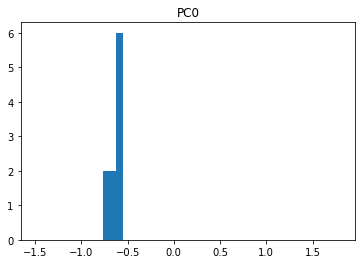

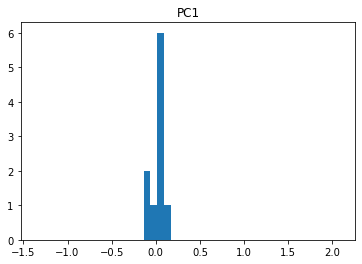

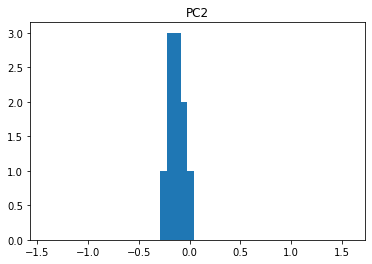

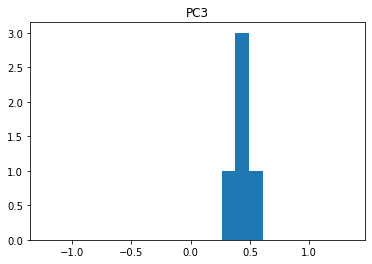

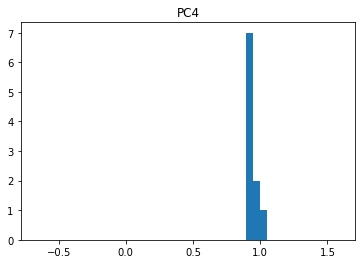

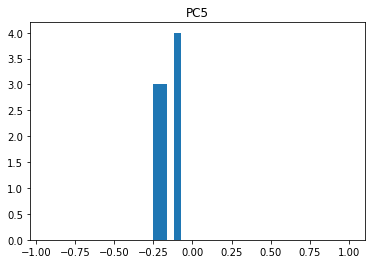

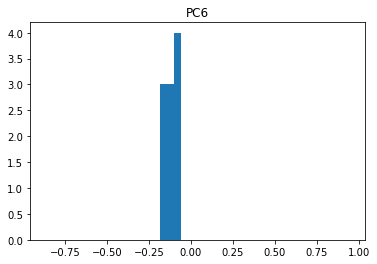

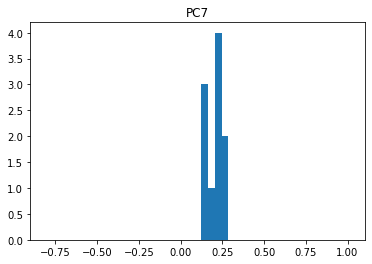

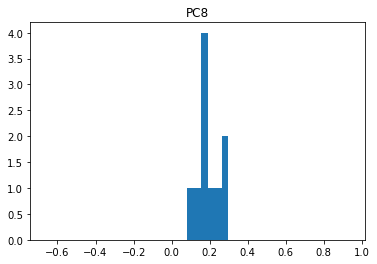

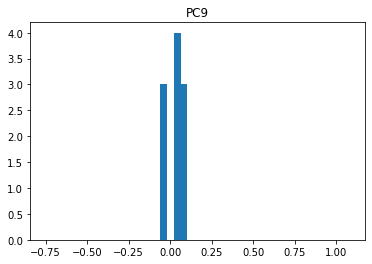

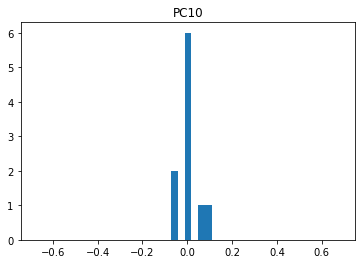

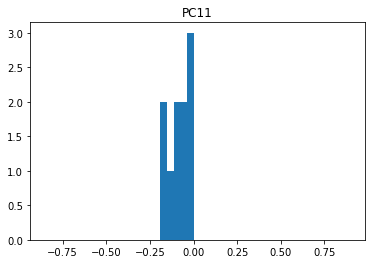

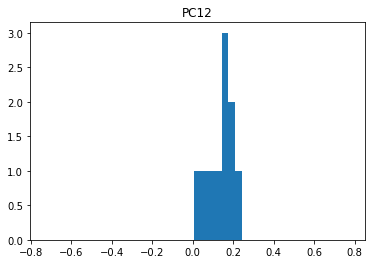

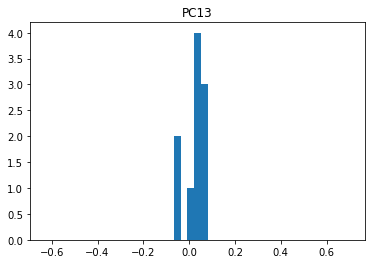

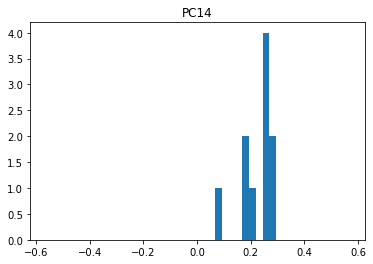

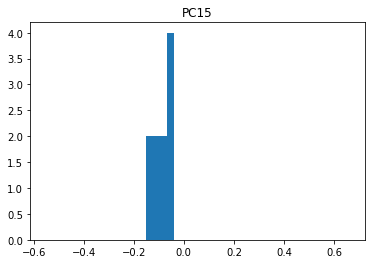

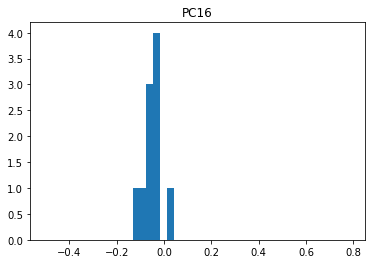

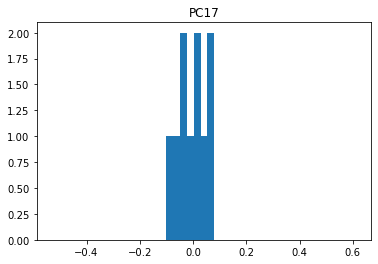

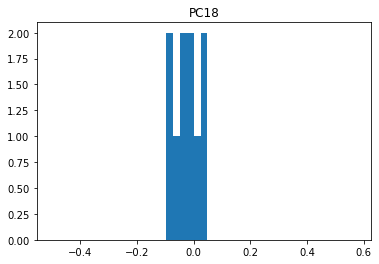

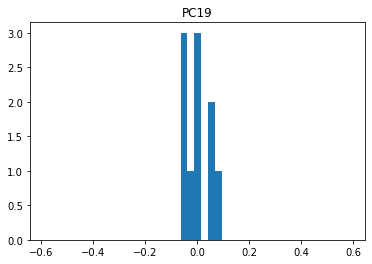

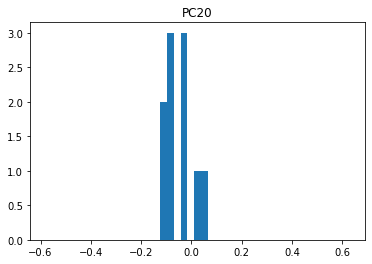

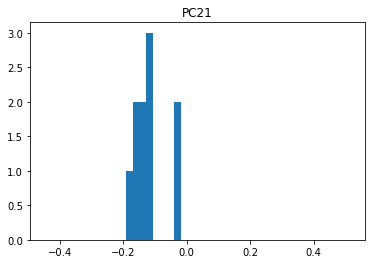

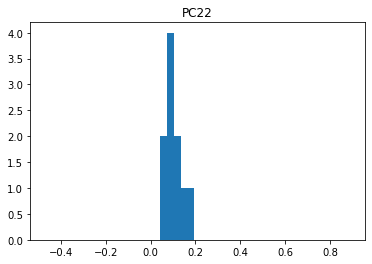

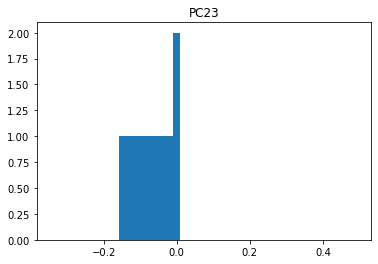

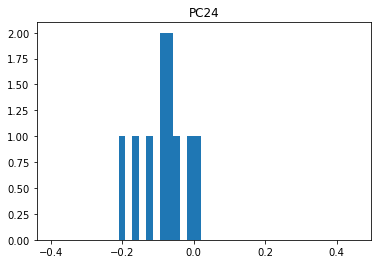

In [23]:
feat_scatter_l = []
for feat in results_df.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(results_df[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(results_df[feat])
    feat_scatter_l.append(feat_scatter)    

In [24]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 0.05074287344043853
Scatter median: 0.049723652304866854
Scatter std: 0.010802067257036392
Scatter max: 0.07502083031466047
Scatter min: 0.031892944899348734


MaxAbsScaler, Euclidean, Ia

NON PCA
Scatter mean: 0.10822062189269697
Scatter median: 0.08390001702324312
Scatter std: 0.09273033952967297
Scatter max: 0.3615067063860504
Scatter min: 0.0

PCA
Scatter mean: 0.22748059656595504
Scatter median: 0.23485067052158148
Scatter std: 0.08590310140277316
Scatter max: 0.3552833440373228
Scatter min: 0.013447031738069838

MaxAbsScaler, Euclidean, SLSN

Scatter mean: 0.1882023265906344
Scatter median: 0.14632144856515017
Scatter std: 0.1839875260098897
Scatter max: 1.046586348913336
Scatter min: 0.006225538066605167

MaxAbsScaler, Euclidean, junk

Scatter mean: 0.18480675721201786
Scatter median: 0.14364864210180578
Scatter std: 0.208412667064402
Scatter max: 1.2017613918543555
Scatter min: 0.002740342445819787